In [99]:
# 出走馬について上位に入る確率を予想し、確率が閾値以上の場合に限り購入することを考える
# 閾値を使わずに購入した場合と閾値以上の場合で比較し、的中率や回収率が改善されるか確認する

In [1]:
# インポート
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
# ! pip install japanize-matplotlib
import japanize_matplotlib
from scipy import stats


def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.95):

    """
    回収率の信頼区間を求める関数

    Parameters
    ----------
    mean       : float           平均回収率（例：1.05）
    std        : float           標準偏差  （例：0.15）
    n          : int             サンプル数（レース数）
    confidence : float, optional 信頼水準（デフォルトは0.95）

    Returns
    -------
    (lower, upper) : tuple of float
        信頼区間の下限値と上限値
    """
    
    # t値（t分布の臨界値）
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    
    # 信頼区間の幅（マージン）
    margin = t_value * std / np.sqrt(n)
    
    # 区間の下限・上限
    lower = mean - margin
    upper = mean + margin
    
    return lower, upper

def handle_missing_val(df, features, enabled, min_horses):
    if not enabled:
        print("⚠ 欠損処理はスキップされました。")
        return df

    print("✅ 欠損処理を開始します...")
    valid_race_ids = []
    processed_groups = []

    for race_id, group in df.groupby('race_id'):
        # 欠損がない行数をカウント
        non_missing_mask = group[features].notnull().all(axis=1)
        non_missing_count = non_missing_mask.sum()

        if non_missing_count < min_horses:
            # → 指定頭数未満 → 除外
            continue
        else:
            # → 指定頭数以上 → 平均値で補完
            for col in features:
                if group[col].isnull().any():
                    mean_val = group[col].mean(skipna=True)
                    group[col] = group[col].fillna(mean_val)
            processed_groups.append(group)

    df_processed = pd.concat(processed_groups, ignore_index=True)
    print(f"✅ 欠損処理後のレコード数: {len(df_processed)}（元: {len(df)}）")
    return df_processed

In [3]:
# CSVファイルの読み込み
# df = pd.read_csv('input_編集後.csv', encoding='utf-8')
num_horses = 9
df = pd.read_csv(f'input_{num_horses}頭_編集後.csv', encoding='utf-8')
df['race_date'] = pd.to_datetime(df['race_date'])  # 日付が文字列なら変換
print(f"dfの行数は {len(df)} ")
# レースID、馬番順に並び替え
df = df.sort_values(by=['race_id', 'horse_number'])
# === 欠損値対応の設定 ===
handle_missing = True  # Trueで対応ON、Falseでスキップ
min_non_missing_horses = num_horses  # この頭数以上であれば補完、それ未満ならレースごと除外

# 欠損処理対象の特徴量を指定（必要に応じて拡張）
missing_check_features = [
    'time_index_average_2',
    'jockey_place_rate_100'
]

dfの行数は 78768 


In [5]:
# === 欠損処理の実行 ===
df_not_handle_missing_val = df.copy()
df_handle_missing_val = handle_missing_val(
    df_not_handle_missing_val,
    features=missing_check_features,
    enabled=handle_missing,
    min_horses=min_non_missing_horses
)
# ---------- 説明変数 ----------------------------
df_feature = df_handle_missing_val.copy()
race_avg_time_index = df_feature.groupby('race_id')['time_index_average_2'].transform('mean')
df_feature['time_index_diff_from_avg'] = df_feature['time_index_average_2'] - race_avg_time_index
race_avg_jockey_place_rate = df_feature.groupby('race_id')['jockey_place_rate_100'].transform('mean')
df_feature['jockey_place_rate_diff_from_avg'] = df_feature['jockey_place_rate_100'] - race_avg_jockey_place_rate
features = [
    'time_index_diff_from_avg',
    'jockey_place_rate_diff_from_avg',
]
# ---------- リーク防止のラベル一括作成 ----------
# 上位4頭 → is_top4
df_feature['is_top4'] = (
    df_feature.groupby('race_id')['finish_rank']
    .rank(method='first') <= num_horses / 2 
).astype(int)

df_feature.to_csv('C:\\Users\\ryo\\Downloads\\df_feature.csv', index=False, encoding='cp932')

✅ 欠損処理を開始します...
✅ 欠損処理後のレコード数: 46701（元: 78768）


In [23]:
# フィルタ条件を適用
filtered_df = df_feature.copy()
## 年
train_year = 2021
valid_year = 2022
if train_year < valid_year:
    min_year = train_year
    max_year = valid_year
else:
    min_year = valid_year
    max_year = train_year
filtered_df = filtered_df[
    (filtered_df['race_date'].dt.year >= min_year) &
    (filtered_df['race_date'].dt.year <= max_year)
]
## 人気
# filtered_df = filtered_df[filtered_df['popularity'] == 2]

# カウント
print(f"filtered_dfの行数は {len(filtered_df)} ")

# ---------- モデル1 ----------
df_m1 = filtered_df.copy()

# ---------- 各モデルの特徴量と目的変数 ----------
X_m1 = df_m1[features]
y_m1 = df_m1['is_top4']

X_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_m1.csv', index=False, encoding='cp932')
y_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_m1.csv', index=False, encoding='cp932')

# ---------- モデル1の学習 ----------
X_train_m1 = X_m1[df_m1['race_date'].dt.year == train_year]
y_train_m1 = y_m1[df_m1['race_date'].dt.year == train_year]
X_val_m1   = X_m1[df_m1['race_date'].dt.year == valid_year]
y_val_m1   = y_m1[df_m1['race_date'].dt.year == valid_year]

print(len(X_train_m1), len(y_train_m1), len(X_val_m1), len(y_val_m1))

base_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

model1 = xgb.XGBClassifier(
    **base_params,
    base_score = 0.5,
    max_depth=1,
    learning_rate=0.06,
    n_estimators=100,
    reg_alpha=0.5,
    reg_lambda=1.0
)
model1.fit(X_train_m1, y_train_m1)

X_train_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_train_m1.csv', index=False, encoding='cp932')
y_train_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_train_m1.csv', index=False, encoding='cp932')
X_val_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_val_m1.csv', index=False, encoding='cp932')
y_val_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_val_m1.csv', index=False, encoding='cp932')

# ============================================================
# ✅ 推論フェーズ（レース単位で順にモデルを適用して1着を予測）
# ============================================================

# 対象とする検証データのみ
df_test = filtered_df[filtered_df['race_date'].dt.year == valid_year].copy()

df_test.to_csv('C:\\Users\\ryo\\Downloads\\tmp.csv', index=False, encoding='cp932')

# 結果格納リスト
full_predictions = []

for race_id, group in df_test.groupby('race_id'):

    # ---------- モデル1 ----------
    group_m1 = group.copy()
    X_test_m1 = group_m1[features]
    group_m1['pred_prob_m1'] = model1.predict_proba(X_test_m1)[:, 1]
    # 上位4頭を選出
    group_m1 = group_m1.sort_values('pred_prob_m1', ascending=False)
    group_m1['selected_in_m1'] = 0
    num = int(num_horses / 2)
    group_m1.iloc[:num, group_m1.columns.get_loc('selected_in_m1')] = 1

    # ✅ finish_rank も含めて出力
    result_cols = [
        'race_id', 'race_date', 'course_id', 'num_horses', 'race_number',
        'weather_name', 'track_condition_name', 'horse_number',
        'finish_rank', 'popularity', 'odds', 'pred_prob_m1', 'selected_in_m1'
    ] + features
    
    full_predictions.append(group_m1[result_cols])

# 全レース結合
full_pred_df = pd.concat(full_predictions, ignore_index=True)

# CSV出力
full_pred_df.to_csv('C:\\Users\\ryo\\Downloads\\race_predictions_all_stages.csv', index=False, encoding='cp932')

print("finish_rank を含めた全段階の予測結果CSVを出力しました。")

### モデルの評価 ###

# モデル1
m1_preds = full_pred_df[full_pred_df['selected_in_m1'] == 1]
m1_total = len(m1_preds)
m1_hits = (m1_preds['finish_rank'] <= num_horses / 2).sum()
m1_accuracy = m1_hits / m1_total if m1_total > 0 else 0

# 出力
print(f"▼ モデル1（上位{int(num_horses / 2)}頭予測）の的中率")
print(f"  予測数: {m1_total}, 的中数: {m1_hits}, 的中率: {m1_accuracy:.4f}（{m1_accuracy:.2%}）\n")

# CSV出力
full_pred_df.to_csv('C:\\Users\\ryo\\Downloads\\full_pred_df.csv', index=False, encoding='cp932')

# ============================
# 人気ごとの1着予想的中率＆回収率
# ============================

# 各レースで pred_prob_m1 が最大の馬を1着予想として抽出
df_pred_top1 = full_pred_df.loc[full_pred_df.groupby('race_id')['pred_prob_m1'].idxmax()].copy()

# 的中フラグ
df_pred_top1['is_hit'] = (df_pred_top1['finish_rank'] == 1).astype(int)

# bet金額（1レースあたり固定）を設定
bet_amount = 100
df_pred_top1['payout'] = df_pred_top1['is_hit'] * df_pred_top1['odds'] * bet_amount

# 人気ごとに集計
pop_stats = df_pred_top1.groupby('popularity').agg(
    total_pred=('is_hit', 'count'),
    hits=('is_hit', 'sum'),
    total_payout=('payout', 'sum')
).reset_index()

# 的中率
pop_stats['accuracy'] = pop_stats['hits'] / pop_stats['total_pred']

# 投資総額（1レースあたり bet_amount）
pop_stats['total_bet'] = pop_stats['total_pred'] * bet_amount

# 回収率（ROI）
pop_stats['roi'] = pop_stats['total_payout'] / pop_stats['total_bet']

# 出力
print("\n📊 人気ごとの1着予想的中率＆回収率（pred_prob_m1最大の馬を1着予想として集計）")
print(pop_stats[['popularity', 'total_pred', 'hits', 'accuracy', 'roi']])


filtered_dfの行数は 20187 
9612 9612 10575 10575


C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:15:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


finish_rank を含めた全段階の予測結果CSVを出力しました。
▼ モデル1（上位4頭予測）の的中率
  予測数: 4700, 的中数: 3002, 的中率: 0.6387（63.87%）


📊 人気ごとの1着予想的中率＆回収率（pred_prob_m1最大の馬を1着予想として集計）
   popularity  total_pred  hits  accuracy       roi
0         1.0         603   302  0.500829  0.805141
1         2.0         264    64  0.242424  0.822727
2         3.0         154    19  0.123377  0.616883
3         4.0          78    10  0.128205  0.914103
4         5.0          40     4  0.100000  1.105000
5         6.0          20     3  0.150000  2.810000
6         7.0           9     1  0.111111  2.077778
7         8.0           7     0  0.000000  0.000000


逐次LOESS計算中: 100%|█████████████████████████████████████████████████████████████| 1121/1121 [00:52<00:00, 21.43it/s]


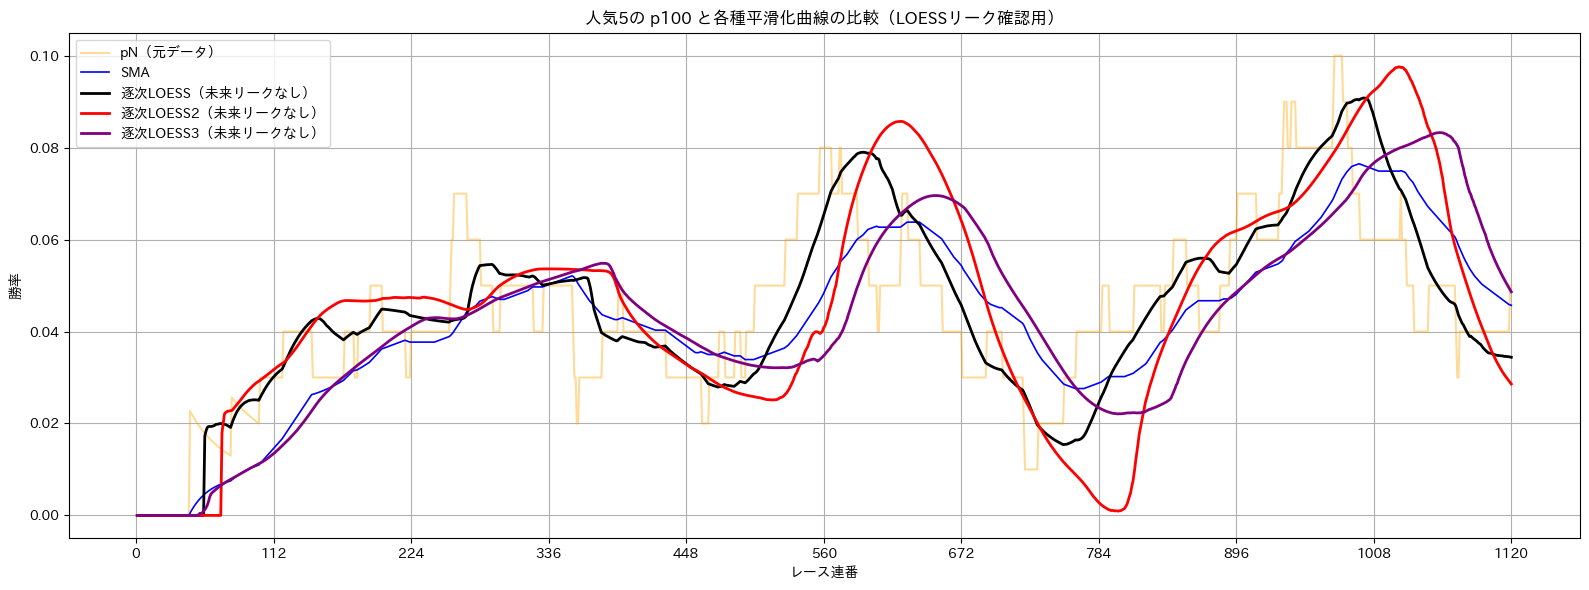

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from tqdm import tqdm

# --- 未来リークなしLOESS関数（逐次LOESS） ---
def rolling_loess(y, frac=0.1, window=200):
    """
    過去データのみを使った逐次LOESS（擬似LOESS）を計算する関数。
    """
    n = len(y)
    loess_seq = np.full(n, np.nan)
    for i in tqdm(range(n), desc="逐次LOESS計算中"):
        start = max(0, i - window)
        end = i + 1
        # i < windowのとき (start, end) = (0, i)
        # i >= windowのとき (start, end) = (i - window, i)
        y_sub = y[start:end]
        x_sub = np.arange(len(y_sub))
        if len(y_sub) < 5:
            loess_seq[i] = y_sub[i]
            continue
        # y_sub, x_subをプロットした際のなめらかな曲線を返す
        smoothed = lowess(y_sub, x_sub, frac=frac, return_sorted=False)
        loess_seq[i] = smoothed[-1]
    return loess_seq

# パラメータ
target_popularity = 5
WINDOW_LONG = 60
N = 100
EMA_SPAN = 20
frac = 1.0
window = 200

# --- 対象人気を指定 ---
df_plot = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()
df_plot['is_win'] = (df_plot['finish_rank'] == 1).astype(int)

# --- p100 / pN 計算 ---
df_plot['p100'] = df_plot['is_win'].rolling(WINDOW_LONG, min_periods=1).mean().shift(1)
df_plot['pN'] = df_plot['is_win'].rolling(N, min_periods=1).mean().shift(1)

# --- 移動平均 (SMA) ---
df_plot['pN_SMA'] = df_plot['pN'].rolling(N, min_periods=1).mean()

# --- 指数移動平均 (EMA) ---
# df_plot['pN_EMA'] = df_plot['pN'].ewm(span=EMA_SPAN, adjust=False).mean()

# --- 移動中央値 ---
# df_plot['pN_median'] = df_plot['pN'].rolling(N, min_periods=1).median()

# --- 通常LOESS（全データ使用・リークあり） ---
# df_plot['pN_LOESS_leaky'] = lowess(df_plot['pN'], np.arange(len(df_plot)), frac=frac, return_sorted=False)

# --- 未来リークなしLOESS（擬似LOESS） ---
df_plot['pN_LOESS_no_leak'] = rolling_loess(df_plot['pN'].values, frac=frac, window=window)
df_plot['pN_LOESS_no_leak_2'] = rolling_loess(df_plot['pN_LOESS_no_leak'].values, frac=frac, window=window)
df_plot['pN_LOESS_no_leak_3'] = rolling_loess(df_plot['pN_SMA'].values, frac=frac, window=window)

# --- グラフ作成 ---
plt.figure(figsize=(16, 6))
x = np.arange(len(df_plot))

plt.plot(x, df_plot['pN'], label='pN（元データ）', color='orange', alpha=0.4)
plt.plot(x, df_plot['pN_SMA'], label='SMA', color='blue', linewidth=1.2)
# plt.plot(x, df_plot['pN_EMA'], label='EMA', color='green', linewidth=1.2)
# plt.plot(x, df_plot['pN_median'], label='移動中央値', color='purple', linewidth=1.2)
# plt.plot(x, df_plot['pN_LOESS_leaky'], label='LOESS（全期間・未来リークあり）', color='red', linestyle='--')
plt.plot(x, df_plot['pN_LOESS_no_leak'], label='逐次LOESS（未来リークなし）', color='black', linewidth=2)
plt.plot(x, df_plot['pN_LOESS_no_leak_2'], label='逐次LOESS2（未来リークなし）', color='red', linewidth=2)
plt.plot(x, df_plot['pN_LOESS_no_leak_3'], label='逐次LOESS3（未来リークなし）', color='purple', linewidth=2)

# 横軸の目盛りは一定間隔
step = max(1, len(x)//10)
plt.xticks(ticks=np.arange(0, len(x), step))

plt.xlabel('レース連番')
plt.ylabel('勝率')
plt.title(f'人気{target_popularity}の p{N} と各種平滑化曲線の比較（LOESSリーク確認用）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess

# --- 信頼区間関数 ---
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.9):
    if n <= 1 or std == 0:
        return (mean, mean)
    t_value = stats.t.ppf((1 + confidence) / 2, df=n - 1)
    margin = t_value * std / np.sqrt(n)
    return (mean - margin, mean + margin)

# --- パラメータ ---
N = 100
bet_amount = 100
EMA_SPAN = 20
prob_threshold = 0.5
frac = 0.1
window = 200
min_odds = 1.1
max_odds = 10000

# --- シミュレーション関数 ---
def simulate_hits(df, cond_col=None, min_odds=None, max_odds=None):
    if cond_col:
        bets = df[df[cond_col]].copy()
    else:
        bets = df.copy()

    if min_odds is not None:
        bets = bets[bets['odds'] >= min_odds]
    if max_odds is not None:
        bets = bets[bets['odds'] <= max_odds]

    total_bets = len(bets)
    total_spent = total_bets * bet_amount

    if total_bets == 0:
        return {
            'bets': 0, 'wins': 0, 'accuracy': 0,
            'roi': 0, 'payout': 0, 'spent': 0,
            'ci': (np.nan, np.nan)
        }

    wins = bets['is_win'].sum()
    accuracy = wins / total_bets
    bets['payout_each'] = bets['is_win'] * bets['odds'] * bet_amount
    payout = bets['payout_each'].sum()
    roi = payout / total_spent if total_spent > 0 else 0
    std = bets['payout_each'].std(ddof=1) if total_bets > 1 else 0
    lower, upper = confidence_interval(roi, std, total_bets)

    return {
        'bets': total_bets,
        'wins': wins,
        'accuracy': accuracy,
        'roi': roi,
        'payout': payout,
        'spent': total_spent,
        'ci': (lower, upper)
    }

# --- 逐次LOESS計算（fillnaオプション & skip_initialオプション付き） ---
def compute_sequential_loess(df, frac, window, fillna_option=None, skip_initial=0):
    df['pN'] = df['is_win'].rolling(N, min_periods=1).mean().shift(1)
    
    # fillnaオプション処理
    if fillna_option is not None:
        df['pN'] = df['pN'].fillna(fillna_option)
    
    loess_seq = []
    for i in range(len(df)):
        if i < skip_initial:
            loess_seq.append(np.nan)
            continue

        start_idx = max(skip_initial, i - window)
        end_idx = i + 1
        if end_idx - start_idx < 2:
            loess_seq.append(df['pN'].iloc[i])
            continue
        smoothed = lowess(df['pN'].iloc[start_idx:end_idx], 
                          np.arange(end_idx - start_idx), frac=frac, return_sorted=False)
        loess_seq.append(smoothed[-1])
        
    df['loess_seq'] = loess_seq
    df['loess_seq_slope'] = np.diff(df['loess_seq'], prepend=np.nan)
    df['loess_seq_slope2'] = np.diff(df['loess_seq_slope'], prepend=np.nan)
    # df['loess_seq_slope'] = np.gradient(df['loess_seq'], edge_order=2)
    # df['loess_seq_slope2'] = np.gradient(df['loess_seq_slope'], edge_order=2)
    
    return df

# --- 条件定義 ---
conditions = {
    '09': lambda df: df['loess_seq_slope'] > 0,
    '10': lambda df: (df['loess_seq_slope'] > 0) & (df['pN'] < df['loess_seq']),
    '11': lambda df: (df['loess_seq_slope'].shift(2) > 0) & (df['loess_seq_slope2'].shift(2) > 0),
    '12': lambda df: (df['loess_seq_slope'].shift(1) > 0) & (df['loess_seq_slope2'].shift(2) > 0),   
    '13': lambda df: df['loess_seq_slope'].shift(1) > 0,
    '14': lambda df: df['loess_seq_slope2'].shift(2) > 0,
    '15': lambda df: (df['pN'] > df['loess_seq']) & (df['loess_seq_slope'].shift(1) > 0),
    '16': lambda df: (df['pN'] > df['loess_seq']),
    '17': lambda df: (df['loess_seq_slope'] >= 0) & (df['loess_seq_slope2'] > 0)
}

# --- ここでどれを計算するか指定 ---
target_cond = '17' # conditionsで定義されているどれか
fillna_option = None  # None または 0 など
skip_initial = N    # 最初の N 行を無視（0またはNにする）

print("\n" + "="*30)
print(f"🎯 条件 {target_cond} 人気ごとシミュレーション")
print("="*30)

results_all = []
all_bets_df = []

for pop in sorted(full_pred_df['popularity'].unique()):
    df_pop = full_pred_df[full_pred_df['popularity'] == pop].copy()
    df_pop['is_win'] = (df_pop['finish_rank'] == 1).astype(int)

    df_pop = compute_sequential_loess(df_pop, frac, window, fillna_option, skip_initial)

    # loess計算直後にCSV出力
    # df_pop.to_csv(f'C:\\Users\\ryo\\Downloads\\loess_seq_cond{target_cond}_pop{pop}.csv',index=False, encoding='cp932')
    
    df_pop['cond'] = conditions[target_cond](df_pop) & (df_pop['pred_prob_m1'] >= prob_threshold)

    res = simulate_hits(df_pop, 'cond', min_odds, max_odds)

    results_all.append({
        'popularity': pop,
        'bets': res['bets'],
        'wins': res['wins'],
        'spent': res['spent'],
        'payout': res['payout'],
        'accuracy': res['accuracy'],
        'roi': res['roi'],
        'ci_lower': res['ci'][0],
        'ci_upper': res['ci'][1]
    })

    all_bets_df.append(df_pop[df_pop['cond']])

df_all_bets = pd.concat(all_bets_df, ignore_index=True)
res_total = simulate_hits(df_all_bets, None, min_odds, max_odds)

df_result = pd.DataFrame(results_all)
df_result['accuracy_pct'] = df_result['accuracy'] * 100
df_result['roi_pct'] = df_result['roi'] * 100

# 合計行追加
df_total = pd.DataFrame([{
    'popularity': '合計',
    'bets': res_total['bets'],
    'wins': res_total['wins'],
    'spent': res_total['spent'],
    'payout': res_total['payout'],
    'accuracy': res_total['accuracy'],
    'roi': res_total['roi'],
    'ci_lower': res_total['ci'][0],
    'ci_upper': res_total['ci'][1],
    'accuracy_pct': res_total['accuracy'] * 100,
    'roi_pct': res_total['roi'] * 100
}])
df_result = pd.concat([df_result, df_total], ignore_index=True)

# --- パラメータ出力 ---
print("\n--- パラメータ設定 ---")
print(f"N={N}, bet_amount={bet_amount}, EMA_SPAN={EMA_SPAN}, prob_threshold={prob_threshold}")
print(f"loess_frac={frac}, min_odds={min_odds}, max_odds={max_odds}")
print(f"fillna_option={fillna_option}, skip_initial={skip_initial}\n")

# 出力
print(df_result[['popularity', 'bets', 'wins', 'spent', 'payout', 'accuracy_pct', 'roi_pct']].to_string(
    index=False,
    formatters={
        'accuracy_pct': '{:.2f}'.format,
        'roi_pct': '{:.2f}'.format,
        'spent': '{:,.0f}'.format,
        'payout': '{:,.0f}'.format
    }
))

# CSV出力
df_result.to_csv(f'C:\\Users\\ryo\\Downloads\\loess_seq_{target_cond}_all_popularity.csv',index=False, encoding='cp932')



🎯 条件 17 人気ごとシミュレーション

--- パラメータ設定 ---
N=100, bet_amount=100, EMA_SPAN=20, prob_threshold=0.5
loess_frac=0.1, min_odds=1.1, max_odds=10000
fillna_option=None, skip_initial=100

popularity  bets  wins  spent payout accuracy_pct roi_pct
       1.0   241    88 24,100 15,000        36.51   62.24
       2.0   202    39 20,200 13,090        19.31   64.80
       3.0   141    16 14,100  8,690        11.35   61.63
       4.0   119    14 11,900  9,580        11.76   80.50
       5.0    72     4  7,200  5,860         5.56   81.39
       6.0    88     2  8,800  5,970         2.27   67.84
       7.0    42     2  4,200  5,750         4.76  136.90
       8.0    12     2  1,200 10,240        16.67  853.33
       9.0     3     0    300      0         0.00    0.00
        合計   920   167 92,000 74,180        18.15   80.63


In [63]:
import pandas as pd
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
from tqdm import tqdm  # 進捗表示用

# --- パラメータ設定 ---
popularities = sorted(full_pred_df['popularity'].unique())  # すべての人気
N = 100               # ローリングウィンドウサイズ
prob_threshold = 0.5  # 予測確率閾値
min_odds = 1.1
max_odds = 10000
bet_amount = 100
loess_frac = 0.1      # LOESSスムージング範囲
skip_initial = N      # 最初の N 行はスキップ

# --- 全人気の結果記録 ---
all_bets = []

for target_pop in popularities:
    print(f"\n--- 人気 {target_pop} 処理中 ---")

    # データ抽出
    df = full_pred_df[full_pred_df['popularity'] == target_pop].copy()
    df = df.sort_values('race_date').reset_index(drop=True)
    df['is_win'] = (df['finish_rank'] == 1).astype(int)

    # --- 逐次LOESS計算 ---
    records = []
    for i in tqdm(range(len(df)), desc=f"人気{target_pop} 逐次LOESS計算"):
        if i < skip_initial:
            records.append({'loess': np.nan, 'slope': np.nan, 'slope2': np.nan})
            continue

        start_idx = max(skip_initial, i - int(loess_frac * len(df)))
        end_idx = i  # 現在行は含めない
        past = df.iloc[start_idx:end_idx].copy()

        past['pN'] = past['is_win'].rolling(N, min_periods=1).mean()

        if len(past) >= 3:
            smoothed = lowess(past['pN'], np.arange(len(past)), frac=1.0, return_sorted=False)
            slope = np.gradient(smoothed, edge_order=2)
            slope2 = np.gradient(slope, edge_order=2)
            loess_last = smoothed[-1]
            slope_last = slope[-1]
            slope2_last = slope2[-1]
        else:
            loess_last = slope_last = slope2_last = np.nan

        records.append({'loess': loess_last, 'slope': slope_last, 'slope2': slope2_last})

    loess_df = pd.DataFrame(records)
    df = pd.concat([df, loess_df], axis=1)

    # --- 購入判定 ---
    df['buy_flag'] = (
        (df['slope'] > 0) &
        (df['slope2'] > 0) &
        (df['pred_prob_m1'] >= prob_threshold) &
        (df['odds'] >= min_odds) &
        (df['odds'] <= max_odds)
    )

    df_bets = df[df['buy_flag']].copy()
    df_bets['payout'] = df_bets['is_win'] * df_bets['odds'] * bet_amount
    df_bets['spent'] = bet_amount
    df_bets['roi'] = (df_bets['payout'] - df_bets['spent']) / df_bets['spent']
    df_bets['popularity'] = target_pop  # 人気情報を保持

    total_bet = df_bets['spent'].sum()
    total_payout = df_bets['payout'].sum()
    roi = total_payout / total_bet if total_bet > 0 else 0
    accuracy = df_bets['is_win'].mean() if len(df_bets) > 0 else 0

    print(f"購入数: {len(df_bets)}, 的中率: {accuracy:.4f} ({accuracy:.2%}), ROI: {roi:.4f} ({roi:.2%})")

    all_bets.append(df_bets)

# --- 全人気をまとめる ---
all_bets_df = pd.concat(all_bets, axis=0)

# CSV出力（必要なら）
all_bets_df.to_csv(
    'C:\\Users\\ryo\\Downloads\\sequential_loess_all_pops.csv',
    index=False, encoding='cp932'
)



--- 人気 1.0 処理中 ---


人気1.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1120/1120 [00:20<00:00, 55.58it/s]


購入数: 227, 的中率: 0.4758 (47.58%), ROI: 0.8502 (85.02%)

--- 人気 2.0 処理中 ---


人気2.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1120/1120 [00:18<00:00, 62.03it/s]


購入数: 171, 的中率: 0.2047 (20.47%), ROI: 0.6977 (69.77%)

--- 人気 3.0 処理中 ---


人気3.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1121/1121 [00:21<00:00, 51.39it/s]


購入数: 124, 的中率: 0.1371 (13.71%), ROI: 0.8742 (87.42%)

--- 人気 4.0 処理中 ---


人気4.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1120/1120 [00:22<00:00, 49.20it/s]


購入数: 106, 的中率: 0.1038 (10.38%), ROI: 1.0632 (106.32%)

--- 人気 5.0 処理中 ---


人気5.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1121/1121 [00:26<00:00, 43.00it/s]


購入数: 49, 的中率: 0.0204 (2.04%), ROI: 0.2143 (21.43%)

--- 人気 6.0 処理中 ---


人気6.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1122/1122 [00:21<00:00, 51.36it/s]


購入数: 38, 的中率: 0.0526 (5.26%), ROI: 0.9526 (95.26%)

--- 人気 7.0 処理中 ---


人気7.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1118/1118 [00:16<00:00, 68.74it/s]


購入数: 15, 的中率: 0.0000 (0.00%), ROI: 0.0000 (0.00%)

--- 人気 8.0 処理中 ---


人気8.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1121/1121 [00:15<00:00, 72.10it/s]


購入数: 6, 的中率: 0.0000 (0.00%), ROI: 0.0000 (0.00%)

--- 人気 9.0 処理中 ---


人気9.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1117/1117 [00:15<00:00, 72.48it/s]


購入数: 0, 的中率: 0.0000 (0.00%), ROI: 0.0000 (0.00%)


In [79]:
# 人気ごと詳細CSV出力
for pop in sorted(full_pred_df['popularity'].unique()):
    df_pop = full_pred_df[full_pred_df['popularity'] == pop].copy()
    df_pop['is_win'] = (df_pop['finish_rank'] == 1).astype(int)

    # 逐次LOESS計算
    df_pop = compute_sequential_loess(df_pop, loess_frac, fillna_option, skip_initial)

    # 各条件列 09,10,11
    for cond_key, cond_func in conditions.items():
        df_pop[f'cond_{cond_key}'] = cond_func(df_pop) & (df_pop['pred_prob_m1'] >= prob_threshold)
        df_pop[f'purchase_{cond_key}'] = df_pop[f'cond_{cond_key}'].astype(int)
    
    # 購入時の勝敗とオッズ
    for cond_key in ['09','10','11']:
        df_pop[f'result_{cond_key}'] = df_pop[f'purchase_{cond_key}'] * df_pop['is_win']
        df_pop[f'odds_{cond_key}'] = df_pop['odds'] * df_pop[f'purchase_{cond_key}']

    # 必要な列を選択
    columns_to_save = list(df_pop.columns)  # 元データの全列＋計算列
    # CSV出力
    df_pop.to_csv(f'C:\\Users\\ryo\\Downloads\\detail_pop_{pop}.csv',
                  index=False, encoding='cp932')
